In [1]:
import pandas as pd
import numpy as np
import locale
import glob
from pandasql import sqldf

# , instead of . 
locale.setlocale(locale.LC_NUMERIC, 'de_DE.UTF-8')


import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
#for LaTex
plt.rcParams['text.usetex'] = True


from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Graphs01').getOrCreate()
# spark02 = SparkSession.builder.appName('Graphs02').getOrCreate()

from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.sql.functions import split, col

class HandlerCols(HandlerTuple):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        a, b = super().create_artists(legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans)
        num_cols = 2
        new_a = []
        new_b = []
        for i in range(0, len(a), num_cols):
            new_a.append(a[i:i+num_cols])
            new_b.append(b[i:i+num_cols])
        return new_a, new_b

#LOAD data from files and prepare them into columns
schema = StructType([
    StructField("value", DoubleType(), True)
    # Add more StructFields for other columns
])

In [29]:
# Specify the path pattern
path_pattern = "Files/dm5/MinMax_temp*"

# List all files matching the pattern
file_list = glob.glob(path_pattern)

# Initialize an empty list to hold DataFrames
dfs = []

# Read each file into a pandas DataFrame and append to the list
for file in file_list:
    df = pd.read_csv(file, sep='\t', header=None)  # Adjust the separator and header as needed
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

df = df.rename(columns={0: 'Resolution',
                   1: 'T_min',
                   2: 'T_max',
                   3: 'Time'})

display(df.head())

,Resolution,T_min,T_max,Time
0,2,5.000000,5.000000,0.000000
1,2,2.978226,6.594137,0.500237
2,2,2.597884,9.326863,1.000473
3,2,0.316907,25.079110,1.500710
4,2,0.109692,2696.411000,2.000946


In [30]:
query = """
    SELECT 
    * FROM (
        SELECT 
            resolution*4*10 AS NUM_X,
            resolution*4*8 AS NUM_Y,
            resolution*4*4 AS NUM_Z,
            *   
        FROM df
    )        
"""
result = sqldf(query, locals())
# Display the result
print(result)

     NUM_X  NUM_Y  NUM_Z  Resolution     T_min        T_max      Time
0       80     64     32           2  5.000000     5.000000  0.000000
1       80     64     32           2  2.978226     6.594137  0.500237
2       80     64     32           2  2.597884     9.326863  1.000473
3       80     64     32           2  0.316907    25.079110  1.500710
4       80     64     32           2  0.109692  2696.411000  2.000946
..     ...    ...    ...         ...       ...          ...       ...
160    360    288    144           9  3.704255     7.004303  6.000043
161    360    288    144           9  3.860005     6.924901  6.500007
162    360    288    144           9  4.002052     7.015453  7.000050
163    360    288    144           9  3.897916     7.741923  7.500014
164    360    288    144           9  4.046552     6.924987  8.000057

[165 rows x 7 columns]


In [31]:
params = ['1.00%', '3.00%', '5.00%', '10.00%']
time_integer = []
for i in params:
    time_integer.append(i.split('.')[0])  # This splits the string at the decimal point and takes the first part
# print(time_integer)

Tables = []

for index, time in enumerate(params):
    query = """
        SELECT 
            Resolution,
            NUM_X,
            NUM_Y,
            NUM_Z,
            SPATIAL_STEP,
            min(T_min) as T_min,
            max(T_max) as T_max,
            Time
        FROM (
            SELECT 
                resolution*4*10 AS NUM_X,
                resolution*4*8 AS NUM_Y,
                resolution*4*4 AS NUM_Z,
                round(0.125/(4*resolution), 5) AS SPATIAL_STEP,
                *   
            FROM df
            WHERE time <> '0.000000'
                and T_min < 20.0
                and T_max < 20.0
        )
        where time like '{time}'
        GROUP BY
            Resolution,
            NUM_X,
            NUM_Y,
            NUM_Z,
            SPATIAL_STEP,
            Time
    """.format(time=time)
    
    result = sqldf(query, locals())
    # Display the result
    # display(result)
    
    query2 = """
            SELECT 
                '$' || NUM_X || ' \\times ' || NUM_Y || ' \\times ' || NUM_Z || '$ ' AS formatted_string,
                SPATIAL_STEP,
                round(T_min, 4) as T_min,
                round(T_max, 4) as T_max
            FROM result
        """
    latex = sqldf(query2, locals())
    # Display the result
    latex = latex.reset_index(drop=True)


    numeric_columns = latex.select_dtypes(include=[np.number]).columns

    numeric_columns = pd.Index([col for col in numeric_columns if col != 'SPATIAL_STEP'])

    # Round the numeric columns to two decimal places
    latex[numeric_columns] = latex[numeric_columns].round(3)

    # Function to format numbers with commas as decimal separators
    def format_with_comma(val):
        if pd.isna(val):
            return val
        return '{:.3f}'.format(val).replace('.', ',')

    # Apply the formatting function to all numeric columns
    latex[numeric_columns] = latex[numeric_columns].map(format_with_comma)


    def format_scientific_notation(val):
        if pd.isna(val):
            return val
        # Convert the number to scientific notation and format it as a string
        scientific_notation = "{:.2e}".format(val)
        # Split the scientific notation into mantissa and exponent
        mantissa, exponent = scientific_notation.split('e')
        # Format the mantissa to have two decimal places and add the LaTeX formatting
        formatted_mantissa = "{:.2f}".format(float(mantissa)).replace('.', ',')
        return r"${} \cdot  10^{{{}}}$".format(formatted_mantissa, int(exponent))

    # Apply the formatting function to the 'SPATIAL_STEP' column
    latex['SPATIAL_STEP'] = latex['SPATIAL_STEP'].apply(format_scientific_notation)


    latex.to_latex('table_' + time_integer[index] + '.tex', index=False)


    Tables.append(result)
    # print(latex)

In [25]:
print(Tables[3])

    Resolution  NUM_X  NUM_Y  NUM_Z  SPATIAL_STEP     T_min     T_max  \
0            2     80     64     32       0.01563  4.790627  6.189915   
1            3    120     96     48       0.01042  4.839493  5.780203   
2            4    160    128     64       0.00781  4.864270  5.573256   
3            5    200    160     80       0.00625  4.877147  5.448421   
4            6    240    192     96       0.00521  4.888325  5.366642   
5            7    280    224    112       0.00446  4.900079  5.302945   
6            8    320    256    128       0.00391  4.908948  5.258489   
7            9    360    288    144       0.00347  4.917383  5.222624   
8           10    400    320    160       0.00313  4.925274  5.192553   
9           11    440    352    176       0.00284  4.932056  5.168351   
10          12    480    384    192       0.00260  4.935876  5.152512   
11          14    560    448    224       0.00223  4.944807  5.122725   

        Time  
0   10.00001  
1   10.00054  
2   1

In [26]:
query2 = """
    SELECT 
        '$' || NUM_X || ' \\times ' || NUM_Y || ' \\times ' || NUM_Z || '$ ' AS formatted_string,
        SPATIAL_STEP,
        round(T_min, 4) as T_min,
        round(T_max, 4) as T_max
    FROM result
"""


latex = sqldf(query2, locals())
# Display the result
latex = latex.reset_index(drop=True)


numeric_columns = latex.select_dtypes(include=[np.number]).columns

numeric_columns = pd.Index([col for col in numeric_columns if col != 'SPATIAL_STEP'])

# Round the numeric columns to two decimal places
latex[numeric_columns] = latex[numeric_columns].round(3)

# Function to format numbers with commas as decimal separators
def format_with_comma(val):
    if pd.isna(val):
        return val
    return '{:.3f}'.format(val).replace('.', ',')

# Apply the formatting function to all numeric columns
latex[numeric_columns] = latex[numeric_columns].map(format_with_comma)


def format_scientific_notation(val):
    if pd.isna(val):
        return val
    # Convert the number to scientific notation and format it as a string
    scientific_notation = "{:.2e}".format(val)
    # Split the scientific notation into mantissa and exponent
    mantissa, exponent = scientific_notation.split('e')
    # Format the mantissa to have two decimal places and add the LaTeX formatting
    formatted_mantissa = "{:.2f}".format(float(mantissa)).replace('.', ',')
    return r"${} \cdot  10^{{{}}}$".format(formatted_mantissa, int(exponent))

# Apply the formatting function to the 'SPATIAL_STEP' column
latex['SPATIAL_STEP'] = latex['SPATIAL_STEP'].apply(format_scientific_notation)



latex.to_latex('table_' +  + '.tex', index=False)


print(latex)


TypeError: bad operand type for unary +: 'str'

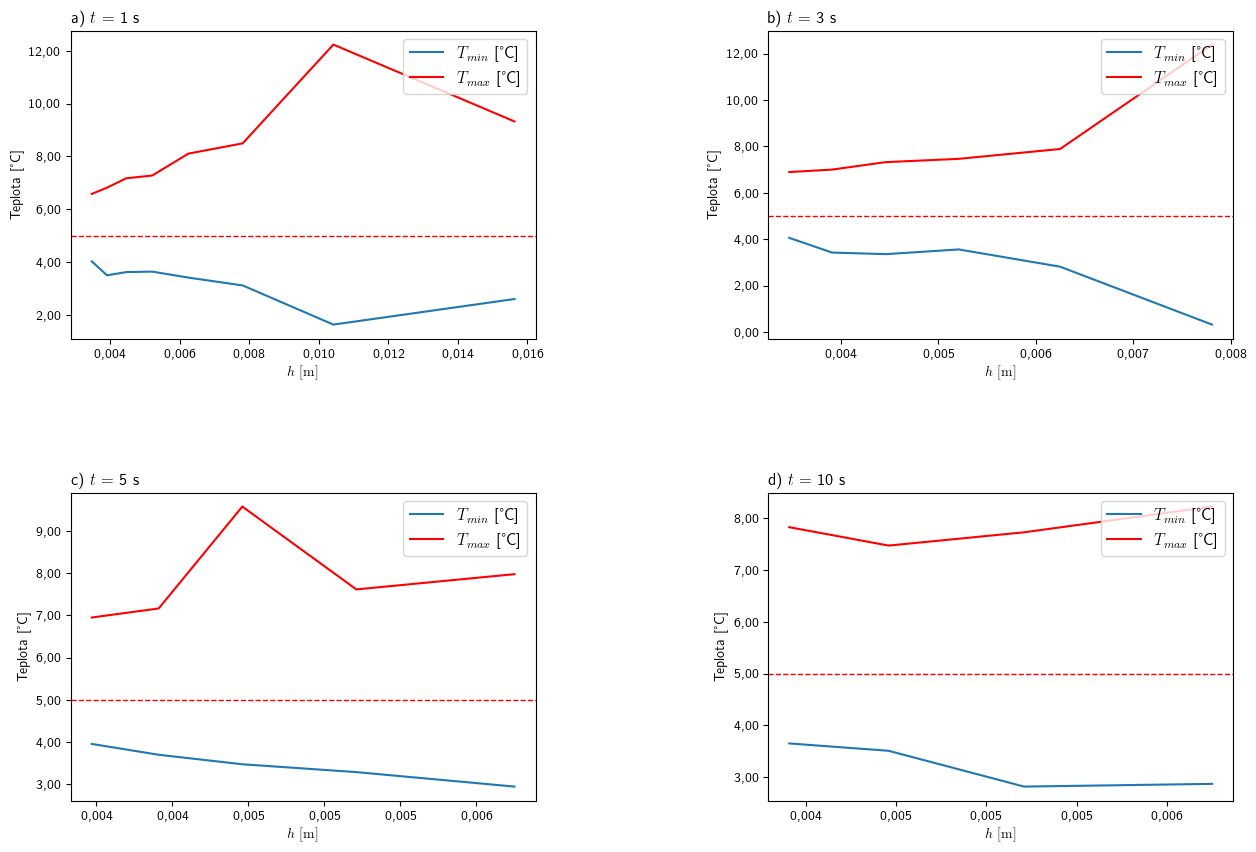

In [32]:
time_integer

plt.rcParams['text.usetex'] = True


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,  10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

abeceda = "abcdefghijklmnopqrstuvwxyz"

# Iterate over each specified spatial step and plot
for i, time in enumerate(time_integer):

    row = i //  2
    col = i %  2
    # Filter the DataFrame for the current spatial step
    filtered_df = Tables[i]  # Assuming 'Tables' is ordered by 'time_integer'
    # print(filtered_df)
    ax[row, col].plot(filtered_df['SPATIAL_STEP'],filtered_df["T_min"], label = "$T_{min}$ [\u00B0C]")
    ax[row, col].plot(filtered_df['SPATIAL_STEP'],filtered_df["T_max"], label = "$T_{max}$ [\u00B0C]", color = 'red')
    ax[row, col].legend(loc='upper right', fontsize='large')
    ax[row, col].set_title( abeceda[i] + ") $t$ = " + time +  " s", loc="left")      
    ax[row, col].set_xlabel("$h \ [\mathrm{m}]$")
    ax[row, col].set_ylabel("Teplota [\u00B0C]")
    ax[row, col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.3f', x)))
    ax[row, col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
    ax[row, col].axhline(y=5.0, color='r', linestyle='dashed', linewidth=1)
    # ax[row, col].invert_xaxis()


# Adjust the layout to accommodate the legend
# fig.tight_layout()
plt.savefig('../../Latex/DP/Img/Kapitola4/d_10m5.pdf', format='pdf', transparent=True)

plt.show()

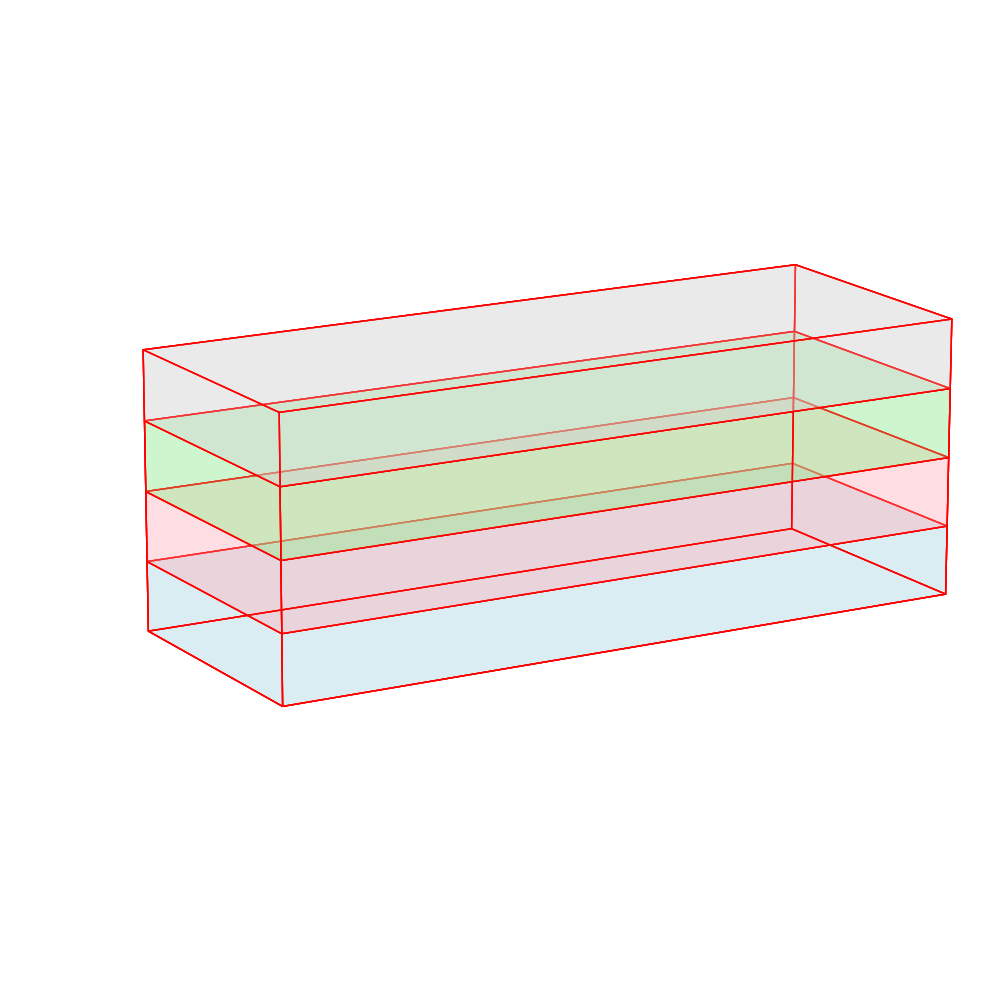

In [266]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Arrow
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(15,  10))
ax = fig.add_subplot(111, projection='3d')

# Dimensions of the rectangular prism
width = 1.5  # Updated width
height = 0.5
depth = 0.5

# Vertices of the rectangular prism
vertices = np.array([
    [0, 0, 0], [width, 0, 0], [width, height, 0], [0, height, 0],  # Bottom vertices
    [0, 0, depth], [width, 0, depth], [width, height, depth], [0, height, depth]  # Top vertices
])

# Generate the sides of the rectangular prism
faces = [
    [vertices[0], vertices[1], vertices[2], vertices[3]],  # Bottom face
    [vertices[4], vertices[5], vertices[6], vertices[7]],  # Top face
    [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front face
    [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back face
    [vertices[1], vertices[2], vertices[6], vertices[5]],  # Right face
    [vertices[0], vertices[3], vertices[7], vertices[4]]   # Left face
]

# Create a 3D polygon collection
prism = Poly3DCollection(faces, linewidths=1, edgecolors='r', alpha=0)
ax.add_collection3d(prism)

# Manually set the aspect ratio to make the plot appear proportional
ax.set_box_aspect([width, height, depth])  # This line helps in adjusting the visual aspect ratio

# Colors for the blocks, assuming you want different colors for visual distinction
block_colors = ['lightblue', 'lightpink', 'lightgreen', 'lightgrey']

# Depth positions for dividing planes, ensuring 4 blocks are distinctly colored
dividing_depths = [depth/4, depth/2, 3*depth/4]

# Function to add a colored block
def add_colored_block(ax, z_start, z_end, color):
    # Define vertices for the block, covering the full x and y range, between z_start and z_end
    vertices = [
        [[0, 0, z_start], [width, 0, z_start], [width, height, z_start], [0, height, z_start]],  # Bottom
        [[0, 0, z_end], [width, 0, z_end], [width, height, z_end], [0, height, z_end]],  # Top
        [[0, 0, z_start], [width, 0, z_start], [width, 0, z_end], [0, 0, z_end]],  # Front
        [[0, height, z_start], [width, height, z_start], [width, height, z_end], [0, height, z_end]],  # Back
        [[width, 0, z_start], [width, height, z_start], [width, height, z_end], [width, 0, z_end]],  # Right
        [[0, 0, z_start], [0, height, z_start], [0, height, z_end], [0, 0, z_end]]  # Left
    ]
    poly = Poly3DCollection(vertices, facecolors=color, linewidths=1, edgecolors='r', alpha=0.25)
    ax.add_collection3d(poly)

# Add blocks, alternating colors
for i, depth_position in enumerate(dividing_depths):
    color = block_colors[i]
    if i == 0:
        add_colored_block(ax, 0, depth_position, color)  # First block
    else:
        add_colored_block(ax, dividing_depths[i-1], depth_position, color)  # Subsequent blocks

# Add the last block, if necessary
if len(dividing_depths) > 0:
    add_colored_block(ax, dividing_depths[-1], depth, block_colors[-1])


# Adjust the axes to show only the min and max values, removing other numbers
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
ax.zaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad=0)
ax.yaxis.set_tick_params(pad=0)
ax.zaxis.set_tick_params(pad=0)

# # Set the limits of the plot
ax.set_xlim([-.2, width])
ax.set_ylim([0, height])
ax.set_zlim([0, depth])

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))

# Additionally, for the axis line color, set it to be transparent
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax._axis3don = False

# Set labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.invert_xaxis()

ax.view_init(elev=15, azim=60)



# origin = np.array([-.25, 0.25, 0])
# length = 0.1
# label_offset = 0.01
# linewidth = 0.5  # Make the line finer
# arrow_length_ratio = 0.2  # Make the arrowhead smaller

# # Create the arrows using quiver with a smaller arrow_length_ratio
# ax.quiver(origin[0], origin[1], origin[2], length, 0, 0, 
#           arrow_length_ratio=arrow_length_ratio, color='black', linewidth=linewidth)
# ax.quiver(origin[0], origin[1], origin[2], 0, length, 0, 
#           arrow_length_ratio=arrow_length_ratio, color='black', linewidth=linewidth)
# ax.quiver(origin[0], origin[1], origin[2], 0, 0, length, 
#           arrow_length_ratio=arrow_length_ratio, color='black', linewidth=linewidth)

# # Text labels for the axes
# ax.text(origin[0] + length + label_offset, origin[1], origin[2], 
#         '$x_1$', color='k', fontsize=10, ha='left', va='center')
# ax.text(origin[0] - 3*label_offset, origin[1] + length + label_offset, origin[2] - label_offset, 
#         '$x_2$', color='k', fontsize=10, ha='center', va='bottom')
# ax.text(origin[0] - label_offset, origin[1] - 4*label_offset, origin[2] + length - 2*label_offset, 
#         '$x_3$', color='k', fontsize=10, ha='center', va='bottom')



plt.tight_layout()

plt.savefig('dif_test.pdf', format='pdf', transparent=True)
plt.show()

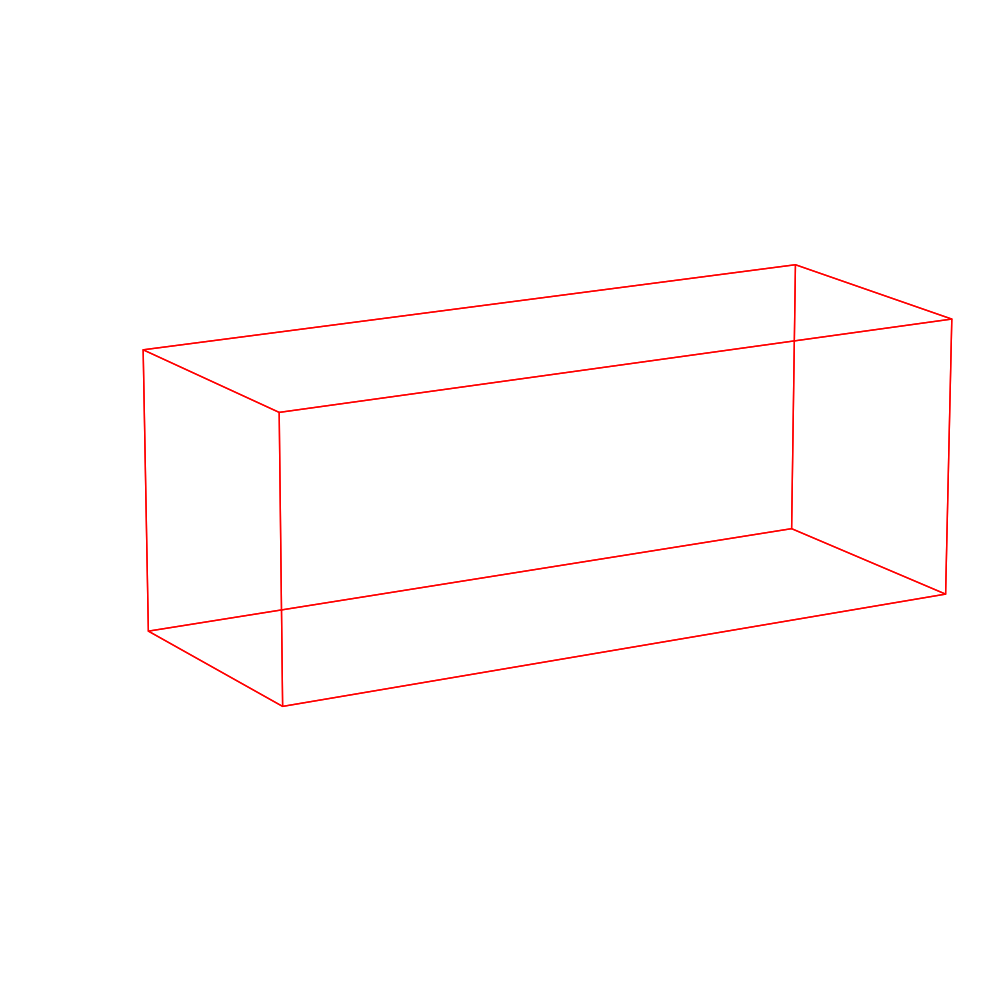

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Arrow
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(15,  10))
ax = fig.add_subplot(111, projection='3d')

# Dimensions of the rectangular prism
width = 1.5  # Updated width
height = 0.5
depth = 0.5

# Vertices of the rectangular prism
vertices = np.array([
    [0, 0, 0], [width, 0, 0], [width, height, 0], [0, height, 0],  # Bottom vertices
    [0, 0, depth], [width, 0, depth], [width, height, depth], [0, height, depth]  # Top vertices
])

# Generate the sides of the rectangular prism
faces = [
    [vertices[0], vertices[1], vertices[2], vertices[3]],  # Bottom face
    [vertices[4], vertices[5], vertices[6], vertices[7]],  # Top face
    [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front face
    [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back face
    [vertices[1], vertices[2], vertices[6], vertices[5]],  # Right face
    [vertices[0], vertices[3], vertices[7], vertices[4]]   # Left face
]

# Create a 3D polygon collection
prism = Poly3DCollection(faces, linewidths=1, edgecolors='r', alpha=0)
ax.add_collection3d(prism)

# Manually set the aspect ratio to make the plot appear proportional
ax.set_box_aspect([width, height, depth])  # This line helps in adjusting the visual aspect ratio



# Adjust the axes to show only the min and max values, removing other numbers
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
ax.zaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad=0)
ax.yaxis.set_tick_params(pad=0)
ax.zaxis.set_tick_params(pad=0)

# # Set the limits of the plot
ax.set_xlim([-.2, width])
ax.set_ylim([0, height])
ax.set_zlim([0, depth])

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))

# Additionally, for the axis line color, set it to be transparent
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax._axis3don = False

# Set labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.invert_xaxis()

ax.view_init(elev=15, azim=60)

plt.tight_layout()

plt.savefig('dif_test.pdf', format='pdf', transparent=True)
plt.show()

In [9]:
from mayavi import mlab
import numpy as np

# Set the dimensions of the volume
width, height, depth = 3.0, 3.0, 3.0

# Set the colors for the blocks, assuming you want different colors for visual distinction
# Mayavi expects colors to be a tuple of (R, G, B) with values between 0 and 1
block_colors = [(0.678, 0.847, 0.902),  # lightblue
                (1.0, 0.753, 0.796),    # lightpink
                (0.565, 0.933, 0.565),  # lightgreen
                (0.827, 0.827, 0.827)]  # lightgrey

# Set the depth positions for dividing planes, ensuring 4 blocks are distinctly colored
dividing_depths = [depth/4, depth/2, 3*depth/4]

# Function to add a colored block
def add_colored_block(z_start, z_end, color):
    # Generate the grid of points for each face of the block
    x = np.array([[0, width, width, 0], [0, width, width, 0]])
    y = np.array([[0, 0, height, height], [0, 0, height, height]])
    z = np.array([[z_start, z_start, z_start, z_start], [z_end, z_end, z_end, z_end]])
    
    # Draw the sides
    mlab.mesh(x, y, z, color=color)
    mlab.mesh(y, z, x, color=color)
    mlab.mesh(z, x, y, color=color)

# Create a figure with a white background
mlab.figure(bgcolor=(1, 1, 1))

# Add blocks with alternating colors
for i, z_current in enumerate([0] + dividing_depths):
    if i == 0:
        z_previous = 0
    else:
        z_previous = dividing_depths[i-1]
    color = block_colors[i % len(block_colors)]
    add_colored_block(z_previous, z_current, color)

# Add the last block
if len(dividing_depths) > 0:
    add_colored_block(dividing_depths[-1], depth, block_colors[-1])

mlab.orientation_axes()
mlab.show()


PROBLEM 05

In [5]:
display(PDlog01_3)

,Temp,\t,Resolution,\\t,PhysDt,\\t,PhysDl,\\\t,PhysDiffusion,\\\t,TransferCoef,\\\\t,InflowVel,\\\\t,Time
0,19.189930,NaN,3.0,NaN,0.000699,NaN,0.010417,NaN,0.002239,NaN,0.01,NaN,1.0,NaN,0.200654
1,18.458220,NaN,3.0,NaN,0.000699,NaN,0.010417,NaN,0.002239,NaN,0.01,NaN,1.0,NaN,0.400609
2,17.779650,NaN,3.0,NaN,0.000699,NaN,0.010417,NaN,0.002239,NaN,0.01,NaN,1.0,NaN,0.600564
3,17.156540,NaN,3.0,NaN,0.000699,NaN,0.010417,NaN,0.002239,NaN,0.01,NaN,1.0,NaN,0.800518
4,16.547550,NaN,3.0,NaN,0.000699,NaN,0.010417,NaN,0.002239,NaN,0.01,NaN,1.0,NaN,1.000473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.191366,NaN,3.0,NaN,0.000699,NaN,0.010417,NaN,0.002239,NaN,0.01,NaN,1.0,NaN,19.200560
96,5.185152,NaN,3.0,NaN,0.000699,NaN,0.010417,NaN,0.002239,NaN,0.01,NaN,1.0,NaN,19.400510
97,5.179421,NaN,3.0,NaN,0.000699,NaN,0.010417,NaN,0.002239,NaN,0.01,NaN,1.0,NaN,19.600470
98,5.170926,NaN,3.0,NaN,0.000699,NaN,0.010417,NaN,0.002239,NaN,0.01,NaN,1.0,NaN,19.800420


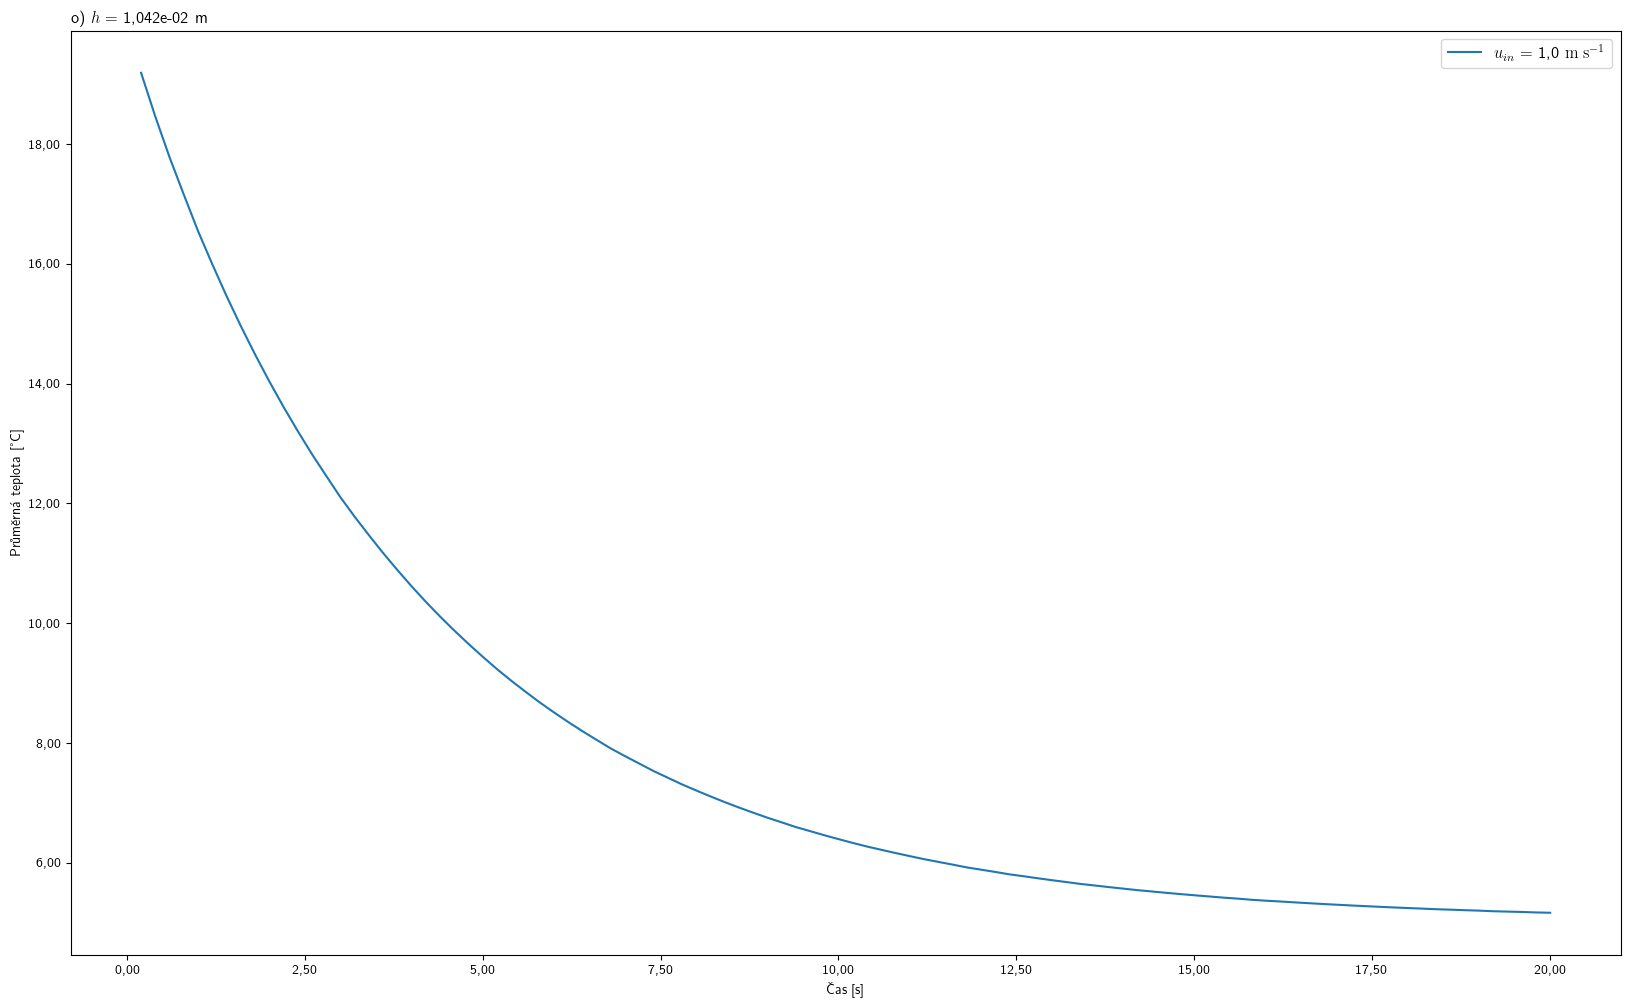

In [6]:
# Divide_transfer_res3 = []
# Divide_transfer_res4 = []
# Divide_transfer_res5 = []

# values = [1.0, 2.0, 4.0, 8.0, 10.0, 12.0, 16.0, 20.0]

# for i in values:
    # Divide_transfer_res3.append(PDlog01_3[(PDlog05_3["InflowVel"] == round(1.0,2)) & (PDlog05_3["Time"] <= 0.1)])
#     Divide_transfer_res4.append(PDlog05_4[(PDlog05_4["InflowVel"] == round(i,2)) & (PDlog05_4["Time"] <= 0.1)])
#     Divide_transfer_res5.append(PDlog05_5[(PDlog05_5["InflowVel"] == round(i,2)) & (PDlog05_5["Time"] <= 0.1)])

# Divide_res = [Divide_transfer_res3, Divide_transfer_res4, Divide_transfer_res5]
Divide_transfer_res3 = PDlog01_3


fig, ax01 = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
# fig.subplots_adjust(hspace=0.2)

abeceda = "abcdefghijklmnopqrstuvwxyz"
abec_field = []
for letter in abeceda:
    abec_field.append(letter)


# for i in range(len(Divide_transfer_res3)):
    # row = int (round(np.floor(i / 2)))
    # col = i % 2
row = 1
col = 1
index = 1
# for index in 1: 
ax01.plot(Divide_transfer_res3["Time"], Divide_transfer_res3["Temp"], label='$u_{in}$ = ' \
    + f'{locale.format_string("%.1f", min(Divide_transfer_res3["InflowVel"]))}'  + " $\mathrm{m \ s^{-1}}$" )
handles, labels = ax01.get_legend_handles_labels()
ax01.legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='large', ncol=1)
ax01.set_title( abec_field[i] + ") $h$ = " + locale.format_string('%.3e', max(Divide_transfer_res3["PhysDl"])) + " m", loc="left")      
ax01.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
ax01.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
#ax01.set_ylim(30,78)
#ax01.set_xlim(-0.005, 0.11)
ax01.set_ylabel("Průměrná teplota [\u00B0C]")
ax01.set_xlabel("Čas [s]")

ax01.set_xlabel("Čas [s]")
# fig.delaxes(ax01)
        
plt.show()

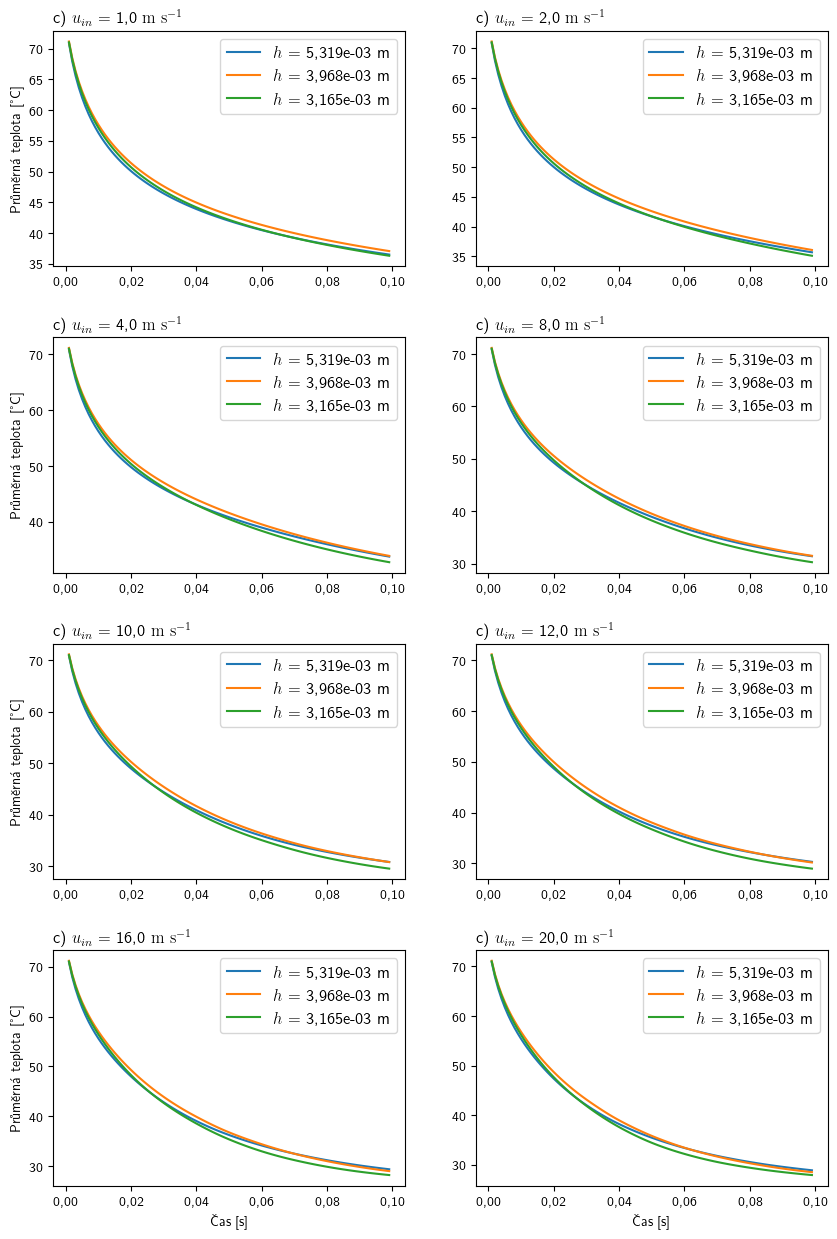

In [48]:
Divide_transfer_res3 = []
Divide_transfer_res4 = []
Divide_transfer_res5 = []

values = [1.0, 2.0, 4.0, 8.0, 10.0, 12.0, 16.0, 20.0]

for i in values:
    Divide_transfer_res3.append(PDlog05_3[(PDlog05_3["InflowVel"] == round(i,2)) & (PDlog05_3["Time"] < 0.1)])
    Divide_transfer_res4.append(PDlog05_4[(PDlog05_4["InflowVel"] == round(i,2)) & (PDlog05_4["Time"] < 0.1)])
    Divide_transfer_res5.append(PDlog05_5[(PDlog05_5["InflowVel"] == round(i,2)) & (PDlog05_5["Time"] < 0.1)])

Divide_res = [Divide_transfer_res3, Divide_transfer_res4, Divide_transfer_res5]


fig, ax01 = plt.subplots(nrows=4, ncols=2, figsize=(10,15)) 
fig.subplots_adjust(hspace=0.3)

abeceda = "abcdefghijklmnopqrstuvwxyz"
abec_field = []
for letter in abeceda:
    abec_field.append(letter)


for index in range(len(values)): 
    row = int (round(np.floor(index / 2)))
    col = index % 2
    for i in range(len(Divide_res)):
        ax01[row,col].plot(Divide_res[i][index]["Time"], Divide_res[i][index]["Temp"], label="$h$ = " + locale.format_string('%.3e', max(Divide_res[i][index]["PhysDl"])) + " m")
        handles, labels = ax01[row,col].get_legend_handles_labels()
        ax01[row,col].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='large', ncol=1)
        ax01[row,col].set_title( abec_field[i] + ") $u_{in}$ = " \
            + f'{locale.format_string("%.1f", min(Divide_res[i][index]["InflowVel"]))}'  + " $\mathrm{m \ s^{-1}}$", loc="left")      
        ax01[row,col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
        ax01[row,col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x)))
        #ax01[row,col].set_ylim(25,78)
        ax01[row,0].set_ylabel("Průměrná teplota [\u00B0C]")
        ax01[3,col].set_xlabel("Čas [s]")
        
plt.show()

PROBLEM 02

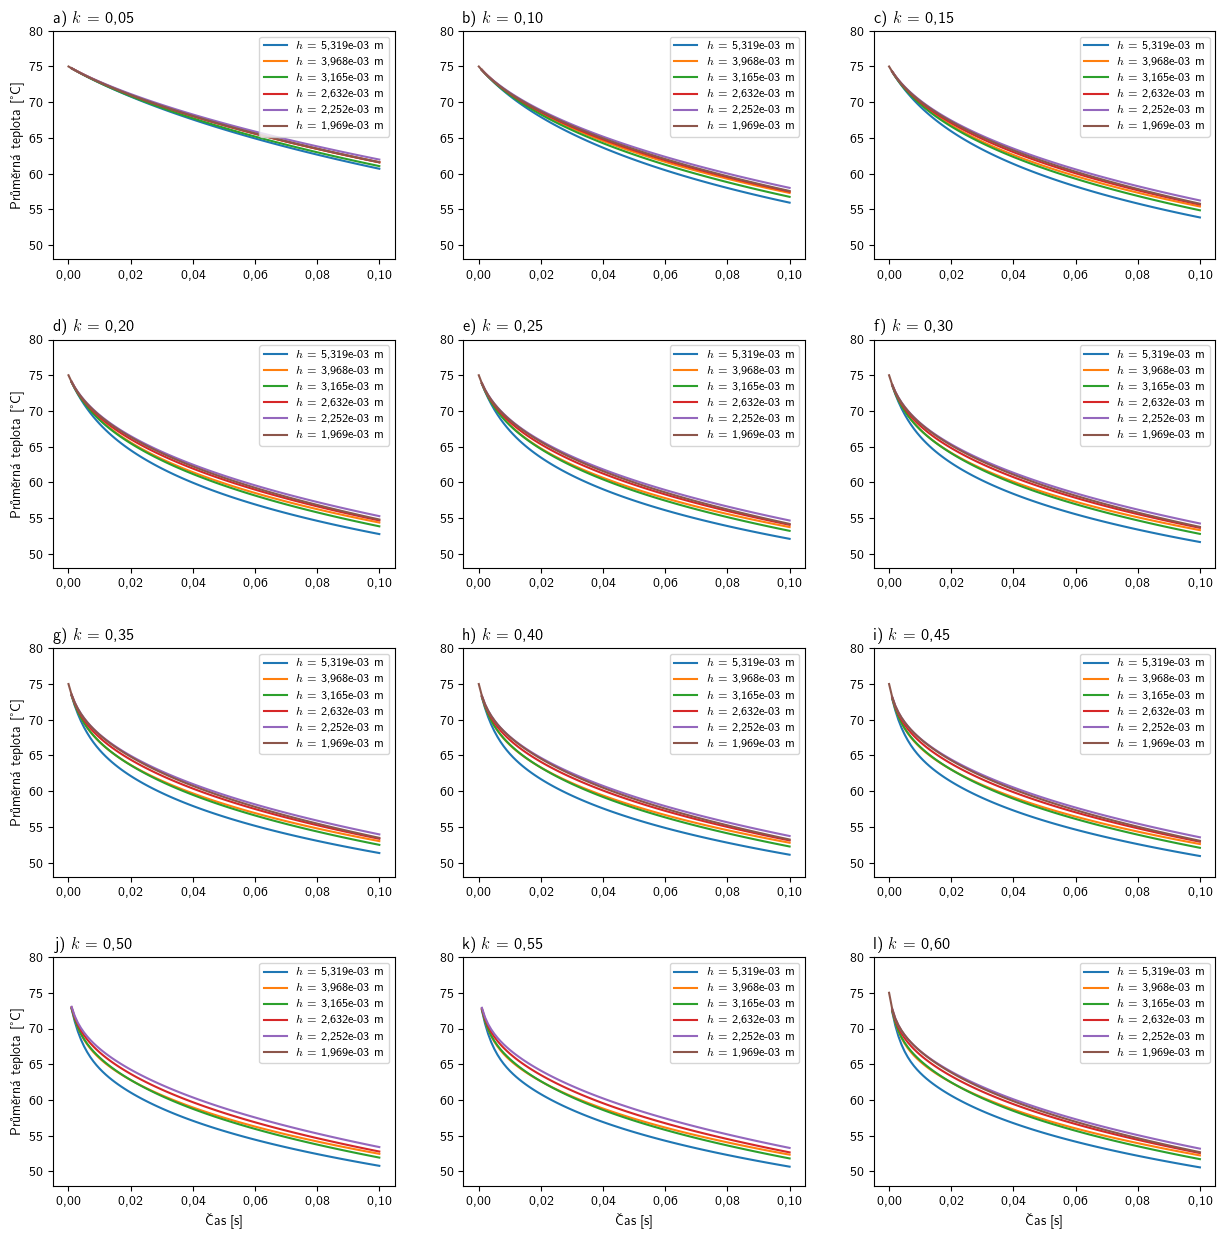

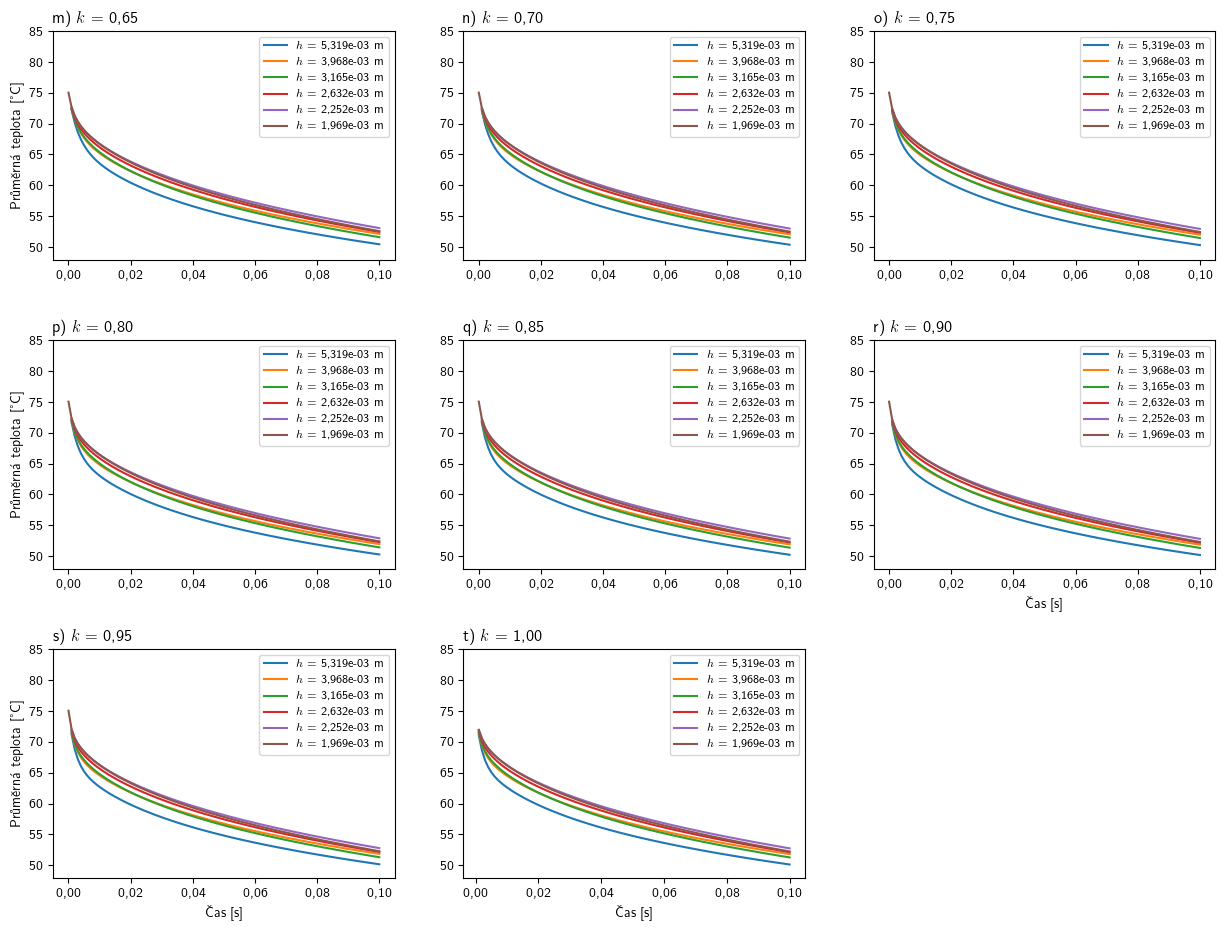

In [49]:
# prepare data for plotting 
Divide_transfer_res3 = []
Divide_transfer_res4 = []
Divide_transfer_res5 = []
Divide_transfer_res6 = []
Divide_transfer_res7 = []
Divide_transfer_res8 = []

#multiple rows with the same time for PDlog02_6 -- need to choose only one
duplicates6 = PDlog02_6[(PDlog02_6['TransferCoef'] == 0.95)].duplicated(subset='Time', keep="last")
PDlog02_6 = PDlog02_6[~((PDlog02_6['TransferCoef'] == 0.95) & duplicates6)]

duplicates7 = PDlog02_7[(PDlog02_7['TransferCoef'] == 0.4)].duplicated(subset='Time', keep="last")
PDlog02_7 = PDlog02_7[~((PDlog02_7['TransferCoef'] == 0.4) & duplicates7)]
duplicates7 = PDlog02_7[(PDlog02_7['TransferCoef'] == 0.8)].duplicated(subset='Time', keep="last")
PDlog02_7 = PDlog02_7[~((PDlog02_7['TransferCoef'] == 0.8) & duplicates7)]

duplicates8 = PDlog02_8[(PDlog02_8['TransferCoef'] == 0.25)].duplicated(subset='Time', keep="last")
PDlog02_8 = PDlog02_8[~((PDlog02_8['TransferCoef'] == 0.25) & duplicates8)]


for i in np.arange(0.05, 1.05, 0.05):
    Divide_transfer_res3.append(PDlog02_3[PDlog02_3["TransferCoef"] == round(i,2)])
    Divide_transfer_res4.append(PDlog02_4[PDlog02_4["TransferCoef"] == round(i,2)])
    Divide_transfer_res5.append(PDlog02_5[PDlog02_5["TransferCoef"] == round(i,2)])
    Divide_transfer_res6.append(PDlog02_6[PDlog02_6["TransferCoef"] == round(i,2)])
    Divide_transfer_res7.append(PDlog02_7[PDlog02_7["TransferCoef"] == round(i,2)])
    Divide_transfer_res8.append(PDlog02_8[PDlog02_8["TransferCoef"] == round(i,2)])
 
Divide_res = [Divide_transfer_res3, Divide_transfer_res4, Divide_transfer_res5, Divide_transfer_res6, Divide_transfer_res7, Divide_transfer_res8]



# plotting 
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
fig.subplots_adjust(hspace=0.35)

abeceda = "abcdefghijklmnopqrstuvwxyz"
abec_field = []
for letter in abeceda:
    abec_field.append(letter)

# for tran in np.arange(0.05, 1.05, 0.05): 
#     index = int ( round((tran - 0.05)/0.05,2) )
for index in range(0,12):    
    row = int (round(np.floor(index / 3)))  
    col = index % 3
    for i in range(len(Divide_res)):
        ax[row,col].plot(Divide_res[i][index]["Time"], Divide_res[i][index]["Temp"], label=f'$h$ = {locale.format_string("%.3e", Divide_res[i][0]["PhysDl"][0])} m')
        handles, labels = ax[row,col].get_legend_handles_labels()
        ax[row,col].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='small', ncol=1)
        ax[row,col].set_title( abec_field[index] + ") $k$ = " + locale.format_string('%.2f', max(Divide_res[0][index]["TransferCoef"])), loc="left")      
        ax[row,col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
        ax[row,col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x)))
        ax[row,col].set_ylim(48,80)
        ax[row,0].set_ylabel("Průměrná teplota [\u00B0C]")
        ax[3,col].set_xlabel("Čas [s]") 
        
plt.show()



# plotting 
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 11))
fig.subplots_adjust(hspace=0.35)

abeceda = "abcdefghijklmnopqrstuvwxyz"
abec_field = []
for letter in abeceda:
    abec_field.append(letter)

# for tran in np.arange(0.05, 1.05, 0.05): 
#     index = int ( round((tran - 0.05)/0.05,2) )
for index in range(12,20):    
    row = int (round(np.floor(index / 3)))  - 4
    col = index % 3
    for i in range(len(Divide_res)):
        ax[row,col].plot(Divide_res[i][index]["Time"], Divide_res[i][index]["Temp"], label=f'$h$ = {locale.format_string("%.3e", Divide_res[i][0]["PhysDl"][0])} m')
        handles, labels = ax[row,col].get_legend_handles_labels()
        ax[row,col].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='small', ncol=1)
        ax[row,col].set_title( abec_field[index] + ") $k$ = " + locale.format_string('%.2f', max(Divide_res[0][index]["TransferCoef"])), loc="left")      
        ax[row,col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
        ax[row,col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x)))
        ax[row,col].set_ylim(48,85)
        ax[row,0].set_ylabel("Průměrná teplota [\u00B0C]")
        ax[2,col].set_xlabel("Čas [s]") 


ax[1,2].set_xlabel("Čas [s]") 
fig.delaxes(ax[2,2])


plt.show()


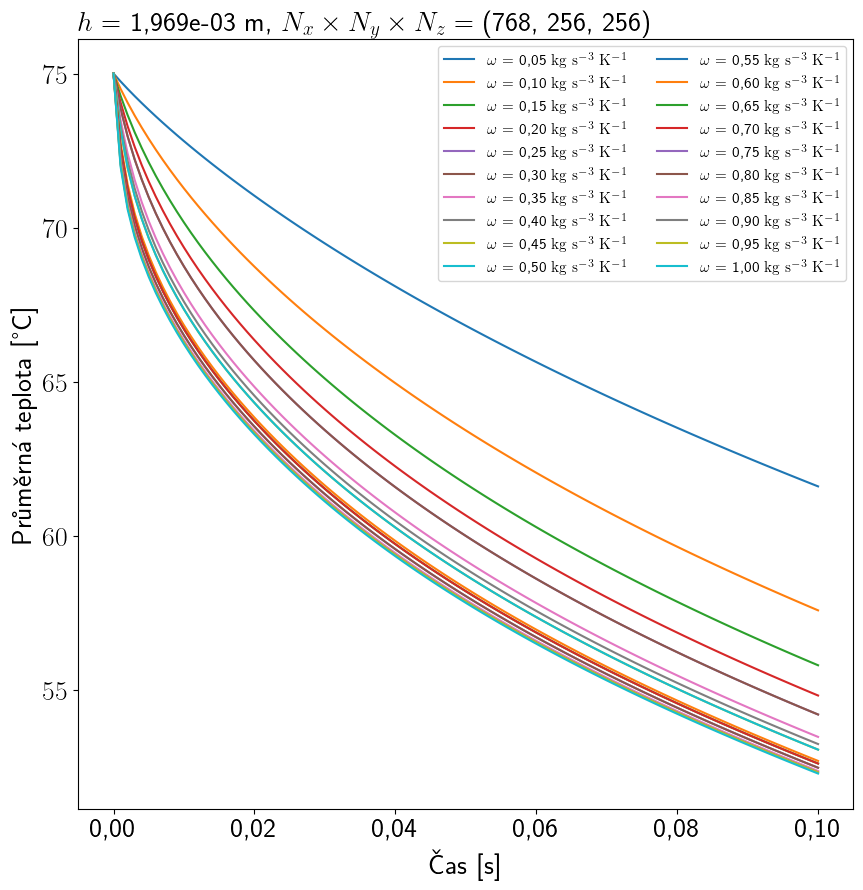

In [50]:
Divide_transfer_res3 = []
Divide_transfer_res4 = []
Divide_transfer_res5 = []
Divide_transfer_res6 = []
Divide_transfer_res7 = []
Divide_transfer_res8 = []

#multiple rows with the same time for PDlog02_6 -- need to choose only one
duplicates = PDlog02_6[(PDlog02_6['TransferCoef'] == 0.95)].duplicated(subset='Time', keep="last")
PDlog02_6 = PDlog02_6[~((PDlog02_6['TransferCoef'] == 0.95) & duplicates)]

duplicates7 = PDlog02_7[(PDlog02_7['TransferCoef'] == 0.4)].duplicated(subset='Time', keep="last")
PDlog02_7 = PDlog02_7[~((PDlog02_7['TransferCoef'] == 0.4) & duplicates7)]

duplicates8 = PDlog02_8[(PDlog02_8['TransferCoef'] == 0.25)].duplicated(subset='Time', keep="last")
PDlog02_8 = PDlog02_8[~((PDlog02_8['TransferCoef'] == 0.25) & duplicates8)]

for i in np.arange(0.05, 1.05, 0.05):
    Divide_transfer_res3.append(PDlog02_3[PDlog02_3["TransferCoef"] == round(i,2)])
    Divide_transfer_res4.append(PDlog02_4[PDlog02_4["TransferCoef"] == round(i,2)])
    Divide_transfer_res5.append(PDlog02_5[PDlog02_5["TransferCoef"] == round(i,2)])
    Divide_transfer_res6.append(PDlog02_6[PDlog02_6["TransferCoef"] == round(i,2)])
    Divide_transfer_res7.append(PDlog02_7[PDlog02_7["TransferCoef"] == round(i,2)])
    Divide_transfer_res8.append(PDlog02_8[PDlog02_8["TransferCoef"] == round(i,2)])


Divide_res = [Divide_transfer_res3, Divide_transfer_res4, Divide_transfer_res5, Divide_transfer_res6, Divide_transfer_res7, Divide_transfer_res8]





fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
for i in np.arange(0.05, 1.05, 0.05):
    index = int ((i - 0.05)//0.05)
    ax.plot(Divide_res[len(Divide_res)-1][index]["Time"], Divide_res[len(Divide_res)-1][index]["Temp"], label=f"$\omega$ = {locale.format_string('%.2f', i)}" + " $\mathrm{kg} \ \mathrm{s}^{-3} \ \mathrm{K}^{-1}$")

# Create the legend with the custom handler for two columns
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='11', ncol=2)

ax.set_xlabel("Čas [s]", fontdict={"fontsize": 20})    
ax.set_ylabel("Průměrná teplota [\u00B0C]",fontdict={"fontsize": 20})
ax.set_title("$h$ = " + locale.format_string('%.3e', Divide_res[len(Divide_res)-1][0]["PhysDl"][0],9) + " m, $N_x \\times N_y \\times N_z =$ (768, 256, 256)", loc="left", fontdict={"fontsize": 20})

# ax[0,1].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='xx-small', ncol=2)
# ax[0,1].set_title("b) h = " + locale.format_string('%.3e', Divide_res[0][0]["PhysDt"][0],9), loc="left")

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

plt.show()

fig.savefig("Fig/Problem02_all_transfers.svg")


## PROBLEM 06

In [51]:
PDlog06_3 = PDlog06_3.drop(PDlog06_3[PDlog06_3["X_dim"] == 0 ].index)
# PDlog06_4 = PDlog06_4.drop(PDlog06_4[PDlog06_4["X_dim"] == 0 ].index)
# PDlog06_8 = PDlog06_8.drop(PDlog06_8[PDlog06_8["X_dim"] == 0 ].index)

X_uni = PDlog06_3["X_dim"].unique()
Y_uni = PDlog06_3["Y_dim"].unique()
Rad_dim = []

for x in X_uni:
    for y in Y_uni:
        if not PDlog06_3[(PDlog06_3["X_dim"] == x) & (PDlog06_3["Y_dim"] == y)].empty:
            Rad_dim.append((x,y))

Divide_transfer_res3 = []
# Divide_transfer_res4 = []
# # Divide_transfer_res5 = []
# # Divide_transfer_res6 = []
# Divide_transfer_res8 = []

#multiple rows with the same time for PDlog02_6 -- need to choose only one

for i in range(len(Rad_dim)):
    Divide_transfer_res3.append(PDlog06_3[(PDlog06_3["X_dim"] == Rad_dim[i][0]) & (PDlog06_3["Y_dim"] == Rad_dim[i][1])])
    # Divide_transfer_res4.append(PDlog06_4[(PDlog06_4["X_dim"] == Rad_dim[i][0]) & (PDlog06_4["Y_dim"] == Rad_dim[i][1])])
    # Divide_transfer_res8.append(PDlog06_8[(PDlog06_8["X_dim"] == Rad_dim[i][0]) & (PDlog06_8["Y_dim"] == Rad_dim[i][1])])

Divide_res = [Divide_transfer_res3] #, Divide_transfer_res4, Divide_transfer_res8]#, Divide_transfer_res5, Divide_transfer_res6, Divide_transfer_res7]


IndexError: list index out of range

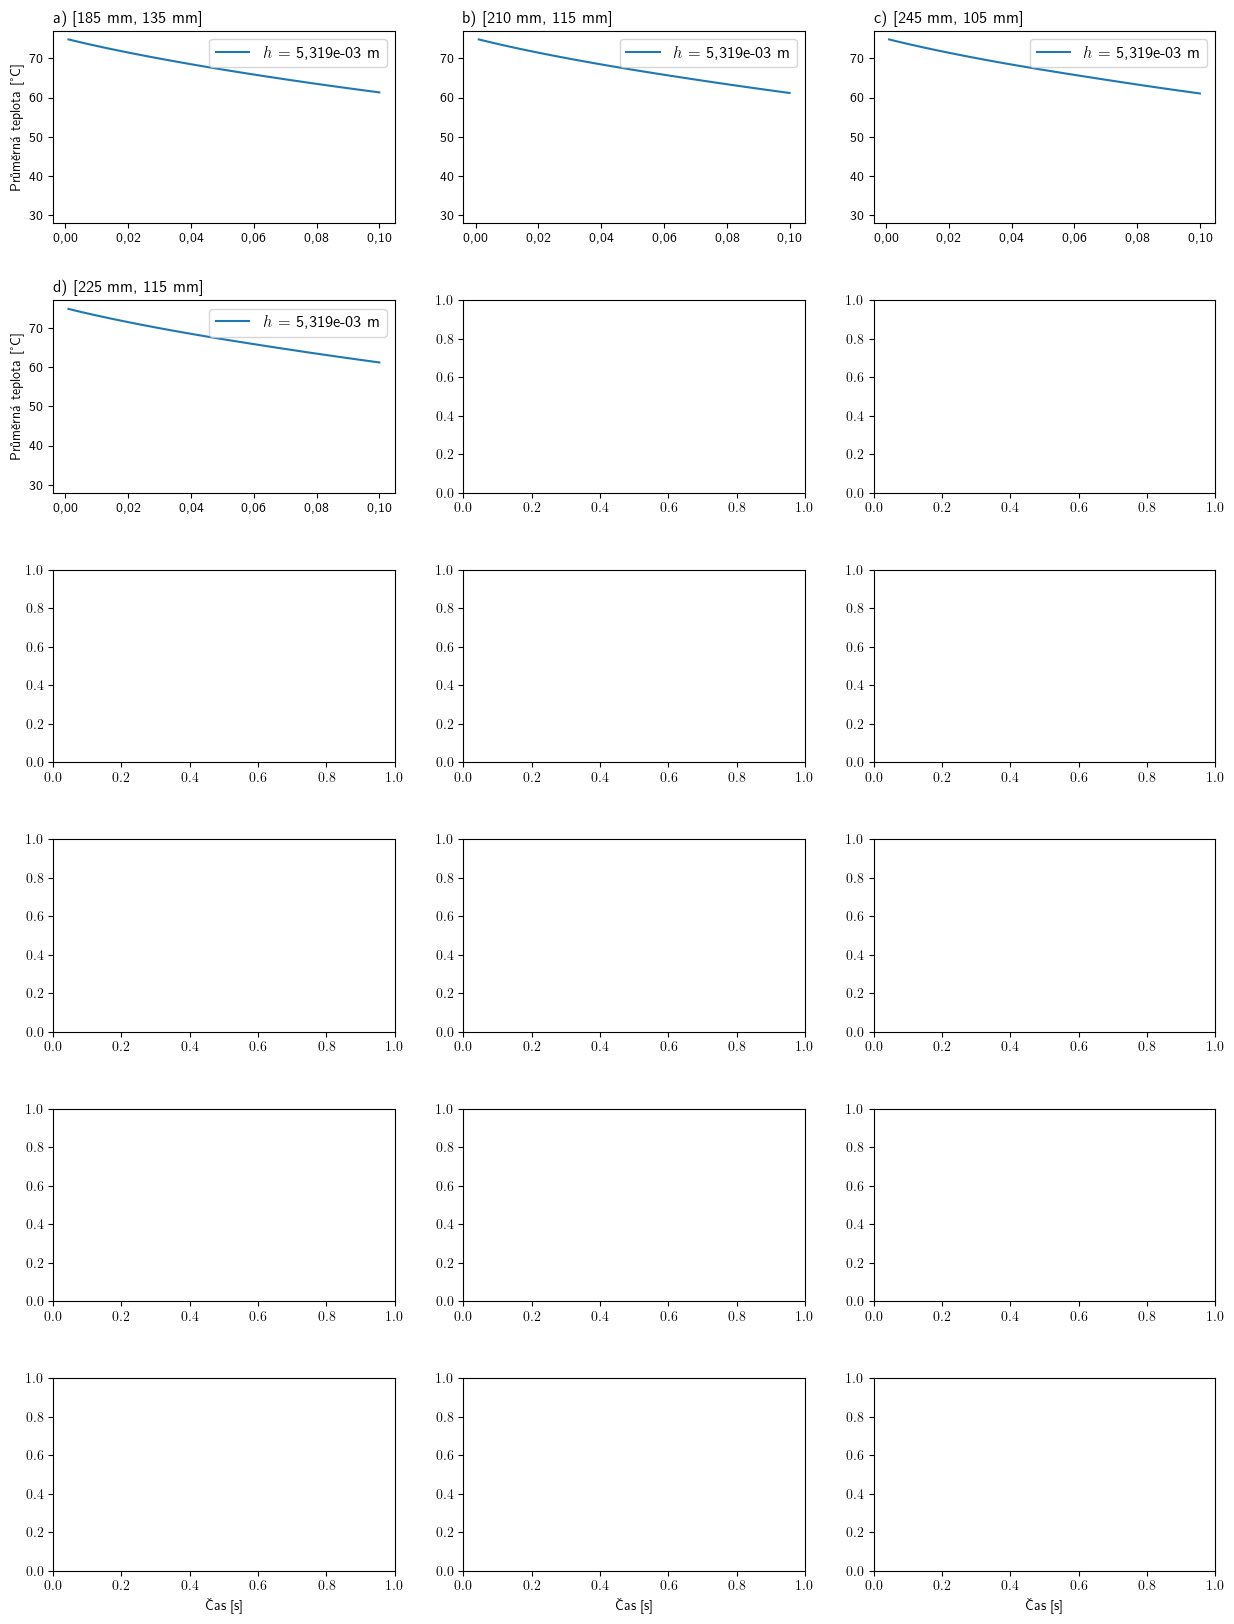

In [52]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(15,20))
fig.subplots_adjust(hspace=0.4)

abeceda = "abcdefghijklmnopqrstuvwxyz"
abec_field = []
for letter in abeceda:
    abec_field.append(letter)

#for rad in range(len(Rad_dim)):
for rad in range(0,18):
    row = int(round(np.floor(rad / 3)))
    col = rad % 3
    for i in range(len(Divide_res)):
        ax[row,col].plot(Divide_res[i][rad]["Time"], Divide_res[i][rad]["Temp"], label=f'$h$ = {locale.format_string("%.3e", Divide_res[i][0]["PhysDl"][0])} m')
        handles, labels = ax[row,col].get_legend_handles_labels()
        ax[row,col].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='large', ncol=1)
        ax[row,col].set_title( abec_field[rad] + ")  [" + locale.format_string('%.0f', max(Divide_res[0][rad]["X_dim"])) + " mm, "+ locale.format_string('%.0f', max(Divide_res[0][rad]["Y_dim"])) + " mm]", loc="left")      
        ax[row,col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
        ax[row,col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x)))
        ax[row,col].set_ylim(28,77)
        ax[row,0].set_ylabel("Průměrná teplota [\u00B0C]")
        ax[5,col].set_xlabel("Čas [s]") 
    
plt.show() 
#ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))   
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
fig.subplots_adjust(hspace=0.4)

abeceda = "abcdefghijklmnopqrstuvwxyz"
abec_field = []
for letter in abeceda:
    abec_field.append(letter)

#for rad in range(len(Rad_dim)):
for rad in range(18,26):
    row = int(round(np.floor(rad / 3))) - 6
    col = rad % 3
    for i in range(len(Divide_res)):
        ax[row,col].plot(Divide_res[i][rad]["Time"], Divide_res[i][rad]["Temp"], label=f'$h$ = {locale.format_string("%.3e", Divide_res[i][0]["PhysDl"][0])} m')
        handles, labels = ax[row,col].get_legend_handles_labels()
        ax[row,col].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='large', ncol=1)
        ax[row,col].set_title( abec_field[rad] + ")  [" + locale.format_string('%.0f', max(Divide_res[0][rad]["X_dim"])) + " mm, "+ locale.format_string('%.0f', max(Divide_res[0][rad]["Y_dim"])) + " mm]", loc="left")      
        ax[row,col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
        ax[row,col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x)))
        ax[row,col].set_ylim(28,77)
        ax[row,0].set_ylabel("Průměrná teplota [\u00B0C]")
        ax[2,col].set_xlabel("Čas [s]")         
        
ax[1,2].set_xlabel("Čas [s]") 

fig.delaxes(ax[2,2])

plt.show() 

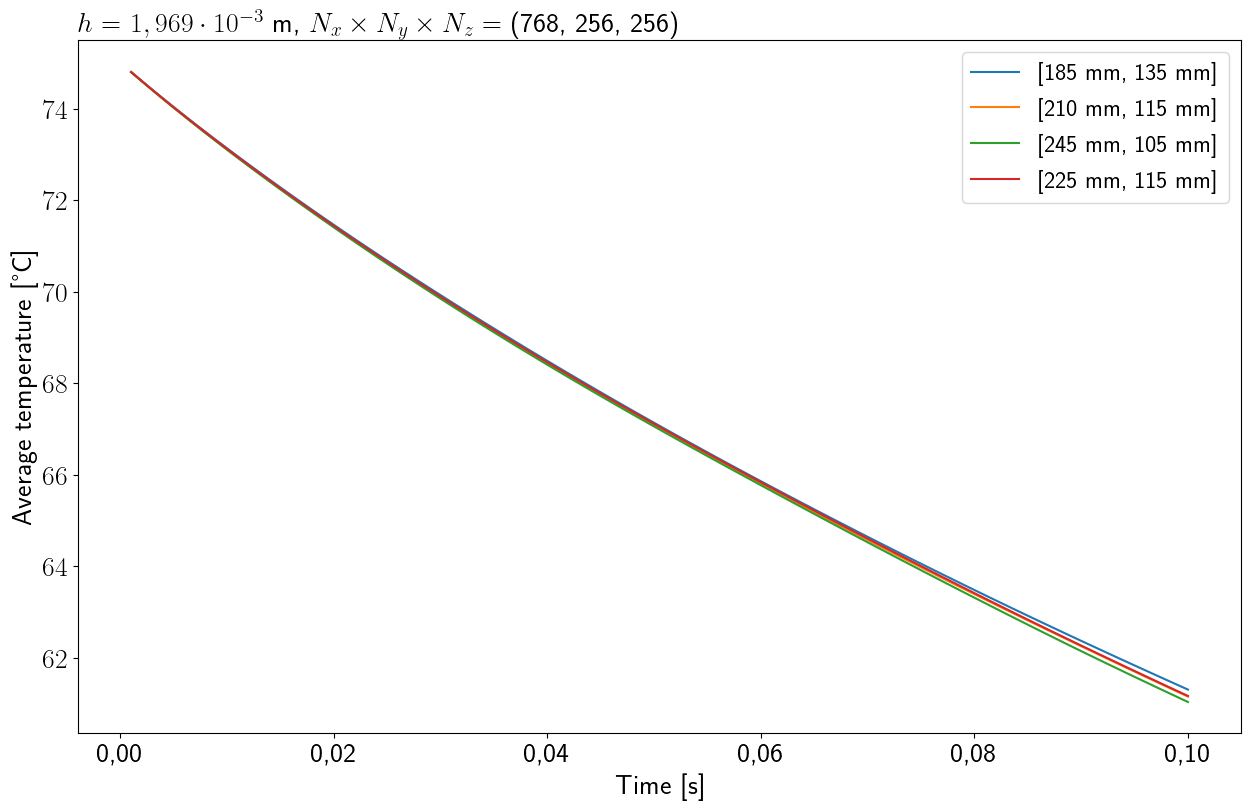

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))
#for rad in range(len(Rad_dim)):
rad = 0
ax.plot(Divide_res[len(Divide_res)-1][rad]["Time"], Divide_res[len(Divide_res)-1][rad]["Temp"], label=f"[{locale.format_string('%.0f', Rad_dim[rad][0])} mm, {locale.format_string('%.0f', Rad_dim[rad][1])} mm]" )
rad = 1
ax.plot(Divide_res[len(Divide_res)-1][rad]["Time"], Divide_res[len(Divide_res)-1][rad]["Temp"], label=f"[{locale.format_string('%.0f', Rad_dim[rad][0])} mm, {locale.format_string('%.0f', Rad_dim[rad][1])} mm]" )
rad = 2
ax.plot(Divide_res[len(Divide_res)-1][rad]["Time"], Divide_res[len(Divide_res)-1][rad]["Temp"], label=f"[{locale.format_string('%.0f', Rad_dim[rad][0])} mm, {locale.format_string('%.0f', Rad_dim[rad][1])} mm]" )
rad = 3
ax.plot(Divide_res[len(Divide_res)-1][rad]["Time"], Divide_res[len(Divide_res)-1][rad]["Temp"], label=f"[{locale.format_string('%.0f', Rad_dim[rad][0])} mm, {locale.format_string('%.0f', Rad_dim[rad][1])} mm]" )

# Create the legend with the custom handler for two columns
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='xx-large', ncol=1)

ax.set_xlabel("Time [s]", fontdict={"fontsize": 20})    
ax.set_ylabel("Average temperature [\u00B0C]", fontdict={"fontsize": 20})
ax.set_title("$h$ = $ 1,969 \cdot 10^{-3}$ m, $N_x \\times N_y \\times N_z =$ (768, 256, 256)", loc="left", fontdict={"fontsize": 20})
# ax.set_yscale("log")
# ax[0,1].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='xx-small', ncol=2)
# ax[0,1].set_title("b) h = " + locale.format_string('%.3e', Divide_res[0][0]["PhysDt"][0],9), loc="left")

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)


plt.show()

fig.savefig("Fig/Probl06_all_rads.svg")

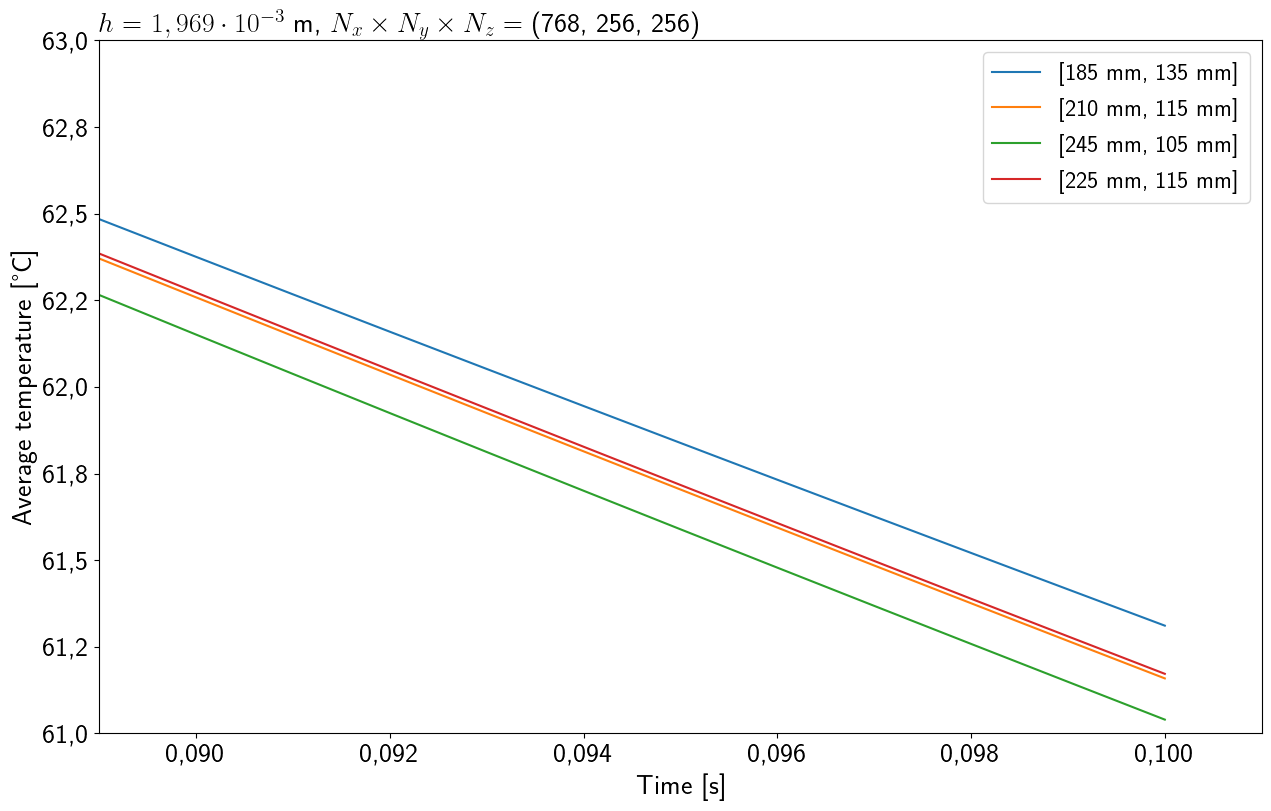

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))
#for rad in range(len(Rad_dim)):
rad = 0
ax.plot(Divide_res[len(Divide_res)-1][rad]["Time"], Divide_res[len(Divide_res)-1][rad]["Temp"], label=f"[{locale.format_string('%.0f', Rad_dim[rad][0])} mm, {locale.format_string('%.0f', Rad_dim[rad][1])} mm]" )
rad = 1
ax.plot(Divide_res[len(Divide_res)-1][rad]["Time"], Divide_res[len(Divide_res)-1][rad]["Temp"], label=f"[{locale.format_string('%.0f', Rad_dim[rad][0])} mm, {locale.format_string('%.0f', Rad_dim[rad][1])} mm]" )
rad = 2
ax.plot(Divide_res[len(Divide_res)-1][rad]["Time"], Divide_res[len(Divide_res)-1][rad]["Temp"], label=f"[{locale.format_string('%.0f', Rad_dim[rad][0])} mm, {locale.format_string('%.0f', Rad_dim[rad][1])} mm]" )
rad = 3
ax.plot(Divide_res[len(Divide_res)-1][rad]["Time"], Divide_res[len(Divide_res)-1][rad]["Temp"], label=f"[{locale.format_string('%.0f', Rad_dim[rad][0])} mm, {locale.format_string('%.0f', Rad_dim[rad][1])} mm]" )

# Create the legend with the custom handler for two columns
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='xx-large', ncol=1)

ax.set_xlabel("Time [s]", fontdict={"fontsize": 20})    
ax.set_ylabel("Average temperature [\u00B0C]", fontdict={"fontsize": 20})
ax.set_title("$h$ = $ 1,969 \cdot 10^{-3}$ m, $N_x \\times N_y \\times N_z =$ (768, 256, 256)", loc="left", fontdict={"fontsize": 20})
ax.set_xlim(0.089,0.101)
ax.set_ylim(61,63)
# ax.set_yscale("log", base=2)
# ax[0,1].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='xx-small', ncol=2)
# ax[0,1].set_title("b) h = " + locale.format_string('%.3e', Divide_res[0][0]["PhysDt"][0],9), loc="left")

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.3f', x)))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.1f', x)))


ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

plt.show()

fig.savefig("Fig/Probl06_all_rads_zoom.svg")

In [ ]:
dog = []

for i in range(4):
    data = Divide_res[len(Divide_res)-1][i]
    dog.append(data[data["Time"] >= 0.1]["Temp"])



In [ ]:
print(dog)

[384    39.69733
Name: Temp, dtype: float64, 390    39.89494
Name: Temp, dtype: float64, 398    39.78059
Name: Temp, dtype: float64, 399    39.53214
Name: Temp, dtype: float64]


In [ ]:
print(max(data[data["Time"] >= 0.1]["Temp"]), min(data[data["Time"] >= 0.1]["Temp"]))


39.53214 39.53214


PROBLEM 04

In [ ]:
# Divide_transfer_res3 = []
# #Divide_transfer_res4 = []
# #Divide_transfer_res5 = []

# values = [1.0, 2.0, 4.0, 8.0, 10.0, 12.0, 16.0, 20.0]

# for i in values:
#     Divide_transfer_res3.append(PDlog04_3[(PDlog04_3["InflowVel"] == round(i,2)) & (PDlog04_3["Time"] <= 0.1)])
# #    Divide_transfer_res4.append(PDlog04_4[(PDlog04_4["InflowVel"] == round(i,2)) & (PDlog04_4["Time"] <= 0.1)])
# #    Divide_transfer_res5.append(PDlog04_5[(PDlog04_5["InflowVel"] == round(i,2)) & (PDlog04_5["Time"] <= 0.1)])

# Divide_res = [Divide_transfer_res3]#, Divide_transfer_res4, Divide_transfer_res5]




# fig, ax01 = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
# fig.subplots_adjust(hspace=0.35)

# abeceda = "abcdefghijklmnopqrstuvwxyz"
# abec_field = []
# for letter in abeceda:
#     abec_field.append(letter)


# for i in range(len(Divide_res)):
#     row = int (round(np.floor(i / 2)))
#     col = i % 2
#     for index in range(len(values)): 
#         ax01[row,col].plot(Divide_res[i][index]["Time"], Divide_res[i][index]["Temp"], label='$u_{in}$ = ' \
#             + f'{locale.format_string("%.1f", min(Divide_res[i][index]["InflowVel"]))}'  + " $\mathrm{m \ s^{-1}}$" )
#         handles, labels = ax01[row,col].get_legend_handles_labels()
#         ax01[row,col].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='small', ncol=1)
#         ax01[row,col].set_title( abec_field[i] + ") $h$ = " + locale.format_string('%.3e', max(Divide_res[i][index]["PhysDl"])) + " m", loc="left")      
#         ax01[row,col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
#         ax01[row,col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x)))
#         #ax01[row,col].set_ylim(30,78)
#         #ax01[row,col].set_xlim(-0.005, 0.11)
#         ax01[row,0].set_ylabel("Průměrná teplota [\u00B0C]")
#         ax01[1,col].set_xlabel("Čas [s]")
        
# plt.show()

In [ ]:
# Divide_transfer_res3 = []
# Divide_transfer_res4 = []
# Divide_transfer_res5 = []

# values = [1.0, 2.0, 4.0]

# for i in values:
#     Divide_transfer_res3.append(PDlog04_3[(PDlog04_3["InflowVel"] == round(i,2)) & (PDlog04_3["Time"] <= 0.1)])
#     Divide_transfer_res4.append(PDlog04_4[(PDlog04_4["InflowVel"] == round(i,2)) & (PDlog04_4["Time"] <= 0.1)])
#     Divide_transfer_res5.append(PDlog04_5[(PDlog04_5["InflowVel"] == round(i,2)) & (PDlog04_5["Time"] <= 0.1)])

# Divide_res = [Divide_transfer_res3, Divide_transfer_res4, Divide_transfer_res5]


# fig, ax01 = plt.subplots(nrows=2, ncols=2, figsize=(15,15)) 

# abeceda = "abcdefghijklmnopqrstuvwxyz"
# abec_field = []
# for letter in abeceda:
#     abec_field.append(letter)


# for index in range(len(values)-1): 
#     row = int (round(np.floor(index / 2)))
#     col = index % 2
#     for i in range(len(Divide_res)):
#         ax01[row,col].plot(Divide_res[i][index]["Time"], Divide_res[i][index]["Temp"], label="$h$ = " + locale.format_string('%.3e', max(Divide_res[i][index]["PhysDl"])) + " m")
#         handles, labels = ax01[row,col].get_legend_handles_labels()
#         ax01[row,col].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='small', ncol=1)
#         ax01[row,col].set_title( abec_field[i] + ") $u_{in}$ = " \
#             + f'{locale.format_string("%.1f", min(Divide_res[i][index]["InflowVel"]))}'  + " $\mathrm{m \ s^{-1}}$", loc="left")      
#         ax01[row,col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
#         ax01[row,col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x)))
#         #ax01[row,col].set_ylim(25,78)
#         ax01[row,0].set_ylabel("Průměrná teplota [\u00B0C]")
#         ax01[1,col].set_xlabel("Čas [s]")
        
# plt.show()

#### PROBLEM 10

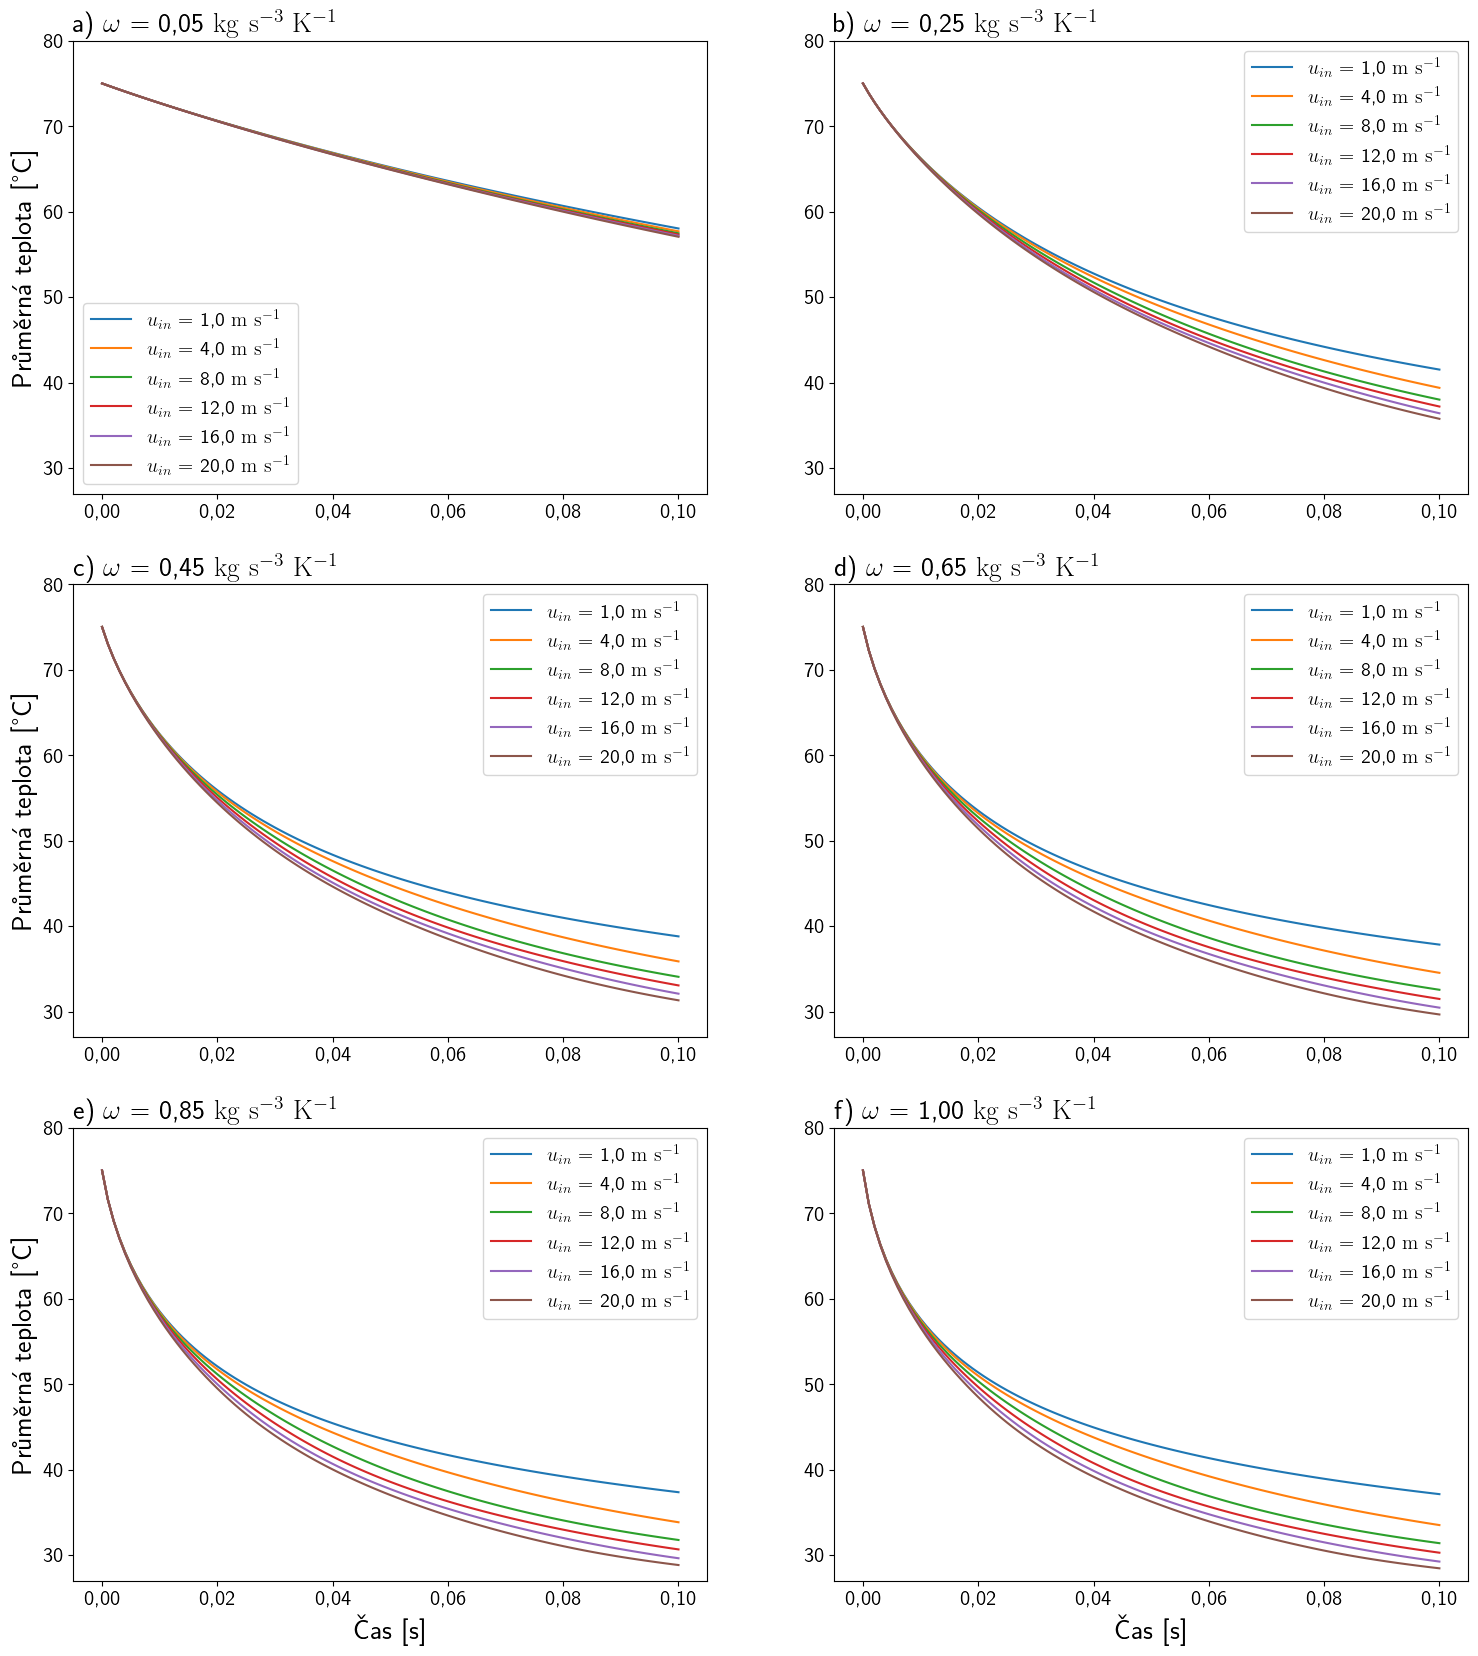

In [ ]:
Divide_transfer_res4 = []

Divide_tra_vel = []

vel_field = [1.0, 4.0, 8.0, 12.0, 16.0, 20.0]
transfer_field = [0.05, 0.25, 0.45, 0.65, 0.85, 1.0]

for j in transfer_field:
    for i in vel_field:
        Divide_transfer_res4.append(PDlog10_4[(PDlog10_4["TransferCoef"] == j) & (PDlog10_4["InflowVel"] == i)])
        
    
Divide_res = [Divide_transfer_res4]



fig, ax01 = plt.subplots(nrows=3, ncols=2, figsize=(18,20))
fig.subplots_adjust(hspace=0.2)

abeceda = "abcdefghijklmnopqrstuvwxyz"
abec_field = []
for letter in abeceda:
    abec_field.append(letter)


for i in range(len(transfer_field)):
    row = int( round(np.floor(i/2)))
    col = i % 2
    for index in range(len(vel_field)): 

        ax01[row,col].plot(Divide_res[0][index+6*i]["Time"], Divide_res[0][index+6*i]["Temp"], label='$u_{in}$ = ' \
                + f'{locale.format_string("%.1f", min(Divide_res[0][index+6*i]["InflowVel"]))}'  + " $\mathrm{m \ s^{-1}}$" )
        handles, labels = ax01[row,col].get_legend_handles_labels()
        if row == 0 and col == 0:
            ax01[row,col].legend(handles, labels, loc='lower left', handler_map={tuple: HandlerCols()}, fontsize='x-large', ncol=1)
        else:
            ax01[row,col].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='x-large', ncol=1)
        ax01[row,col].set_title( abec_field[i] + ") $\omega$ = " + locale.format_string('%.2f', max(Divide_res[0][index+6*i]["TransferCoef"])) + " $\mathrm{kg} \ \mathrm{s}^{-3} \ \mathrm{K}^{-1}$", loc="left", fontdict={"fontsize": 20})      
        ax01[row,col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
        ax01[row,col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x)))
        ax01[row,col].set_ylim(27,80)
        #ax01[row,col].set_xlim(-0.005, 0.11)
        ax01[row,0].set_ylabel("Průměrná teplota [\u00B0C]", fontdict={"fontsize": 20})
        ax01[2,col].set_xlabel("Čas [s]", fontdict={"fontsize": 20})
        ax01[row,col].tick_params(axis='y', labelsize=15)
        ax01[row,col].tick_params(axis='x', labelsize=15)

# ax01[0,1].set_xlabel("Čas [s]")        
plt.show()

fig.savefig("Fig/Probl10_a.svg")

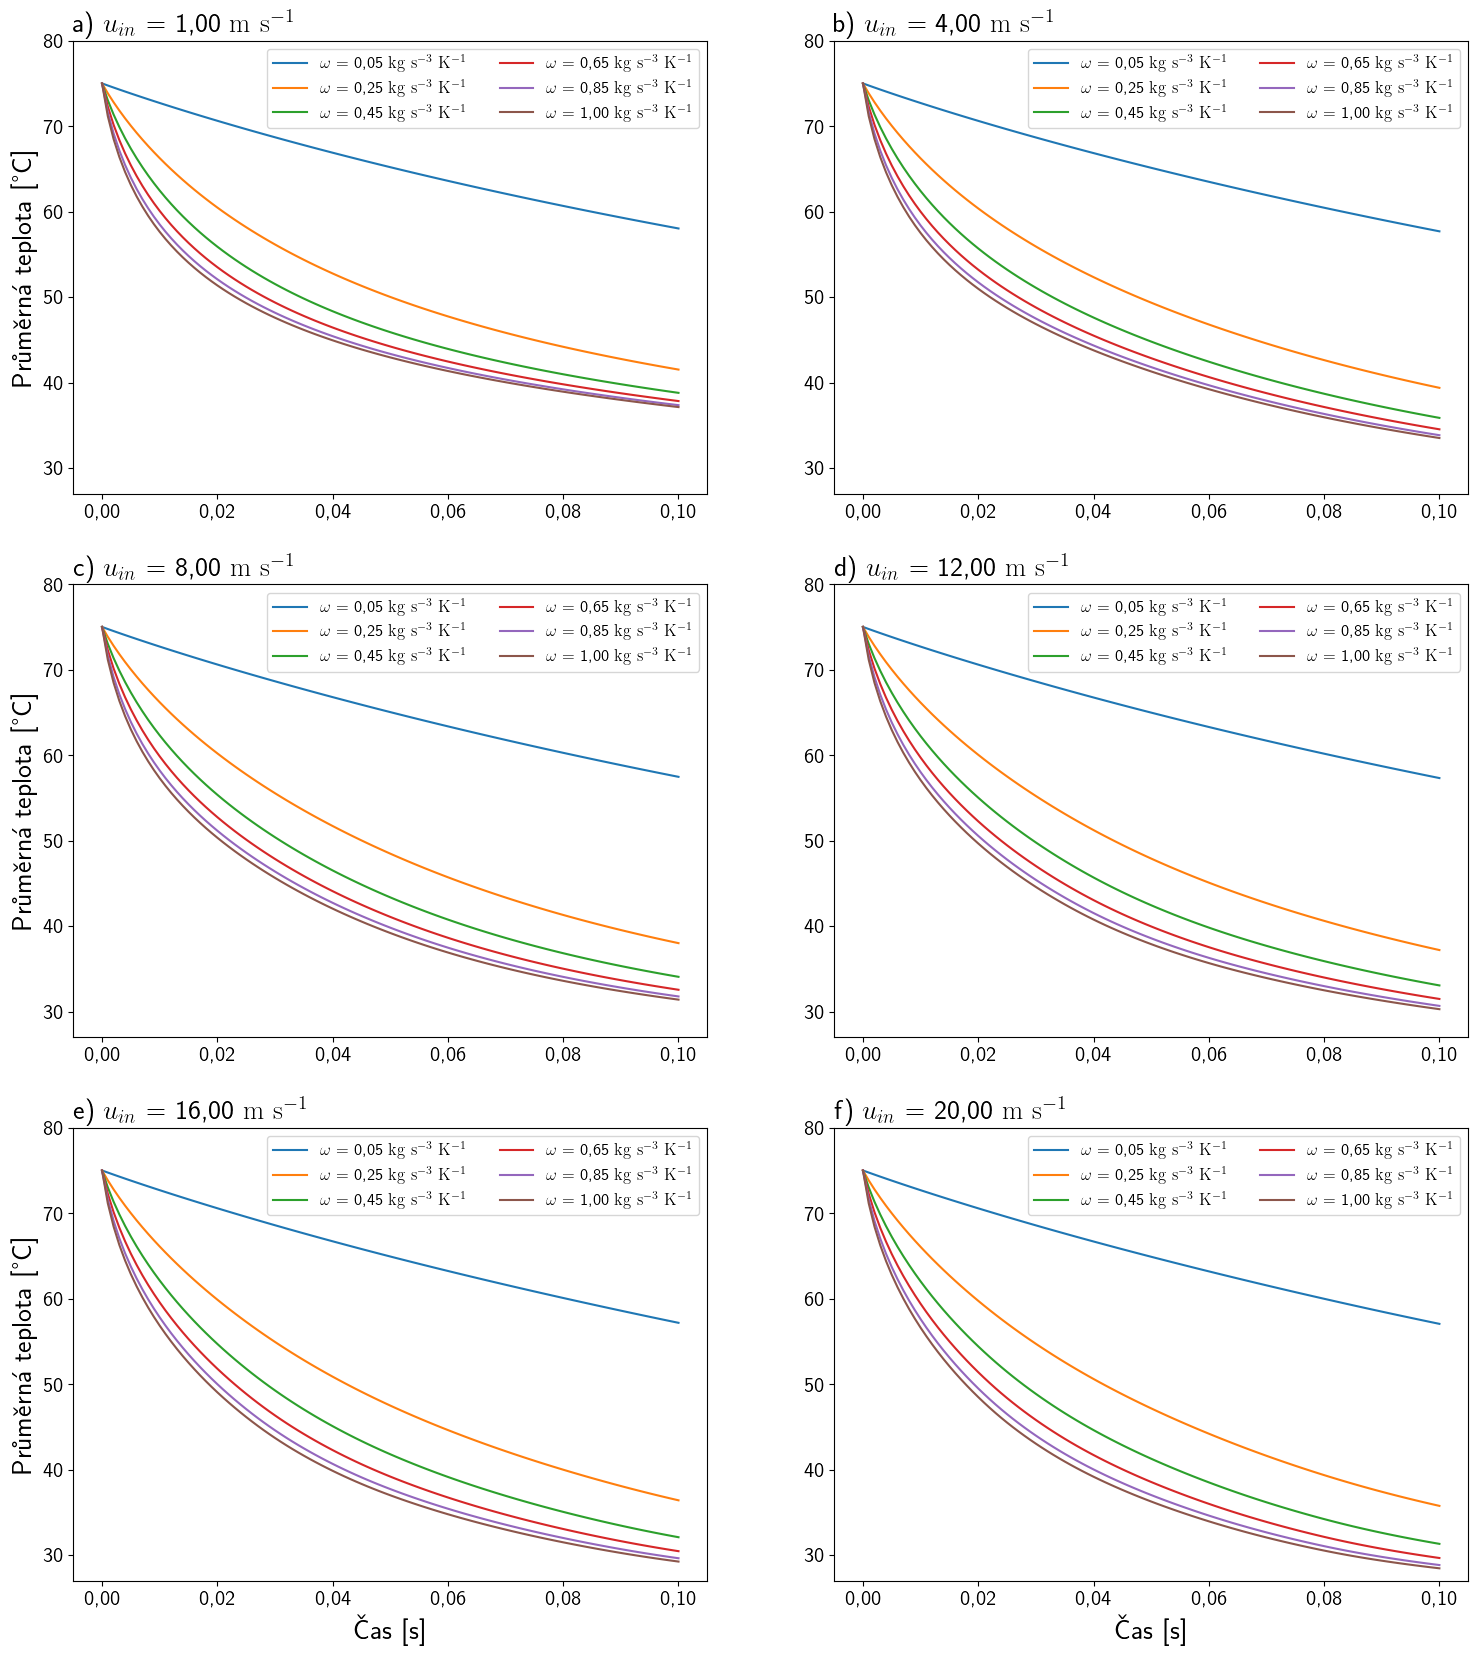

In [ ]:
Divide_transfer_res4 = []

Divide_tra_vel = []

vel_field = [1.0, 4.0, 8.0, 12.0, 16.0, 20.0]
transfer_field = [0.05, 0.25, 0.45, 0.65, 0.85, 1.0]

for j in transfer_field:
    for i in vel_field:
        Divide_transfer_res4.append(PDlog10_4[(PDlog10_4["TransferCoef"] == j) & (PDlog10_4["InflowVel"] == i)])
        
    
Divide_res = [Divide_transfer_res4]



fig, ax01 = plt.subplots(nrows=3, ncols=2, figsize=(18,20))
fig.subplots_adjust(hspace=0.2)

abeceda = "abcdefghijklmnopqrstuvwxyz"
abec_field = []
for letter in abeceda:
    abec_field.append(letter)


for i in range(len(vel_field)):
    row = int( round(np.floor(i/2)))
    col = i % 2
    for index in range(len(transfer_field)): 

        ax01[row,col].plot(Divide_res[0][6*index+i]["Time"], Divide_res[0][6*index+i]["Temp"], label='$\omega$ = ' \
                + f'{locale.format_string("%.2f", min(Divide_res[0][index*6+i]["TransferCoef"]))}'  + " $\mathrm{kg} \ \mathrm{s}^{-3} \ \mathrm{K}^{-1}$" )
        handles, labels = ax01[row,col].get_legend_handles_labels()
        ax01[row,col].legend(handles, labels, loc='upper right', handler_map={tuple: HandlerCols()}, fontsize='large', ncol=2)
        ax01[row,col].set_title( abec_field[i] + ") $u_{in}$ = " + locale.format_string('%.2f', max(Divide_res[0][6*index+i]["InflowVel"])) + " $\mathrm{m \ s^{-1}}$", loc="left", fontdict={"fontsize": 20})      
        ax01[row,col].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.2f', x)))
        ax01[row,col].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x)))
        ax01[row,col].set_ylim(27,80)
        #ax01[row,col].set_xlim(-0.005, 0.11)
        ax01[row,0].set_ylabel("Průměrná teplota [\u00B0C]", fontdict={"fontsize": 20})
        ax01[2,col].set_xlabel("Čas [s]", fontdict={"fontsize": 20})
        ax01[row,col].tick_params(axis='y', labelsize=15)
        ax01[row,col].tick_params(axis='x', labelsize=15)
# ax01[0,1].set_xlabel("Čas [s]")        
plt.show()

fig.savefig("Fig/Probl10_b.svg")